# Embedding Analysis: Concepts vs. Summaries

This notebook analyzes semantic embeddings for 10,000 papers to compare how concepts and summary sections are distributed in embedding space.

**Goal**: Understand whether concepts are dispersed (enabling diverse discovery paths) while summaries cluster (providing coherent narratives).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import umap
import warnings
warnings.filterwarnings('ignore')

# Professional color scheme (like ads_keywords)
sns.set_style('whitegrid')
sns.set_palette('deep')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

## 1. Load Data

We load embeddings for 10,000 sampled papers (OpenAI text-embedding-3-large, 3072 dimensions):
- **Abstract embeddings**: One per paper
- **Section embeddings**: Six per paper (background, motivation, methodology, results, interpretation, implication)
- **Concept embeddings**: Pre-computed for all 9,999 concepts

We also load the paper-concept mappings to know which concepts are assigned to each paper.

In [2]:
print("Loading embeddings...")

# Abstracts
abstract_data = np.load('abstract_embeddings.npz', allow_pickle=True)
abstract_embeddings = abstract_data['embeddings']
abstract_ids = list(abstract_data['arxiv_ids'])

# Concepts
concept_data = np.load('../concepts_embeddings.npz')
all_concept_embeddings = concept_data['embeddings']

paper_concepts = pd.read_csv('../papers_concepts_mapping.csv.gz')
paper_concepts_sample = paper_concepts[paper_concepts['arxiv_id'].isin(abstract_ids)]

concept_labels_in_sample = paper_concepts_sample['label'].unique()
concept_embeddings = all_concept_embeddings[concept_labels_in_sample]

# Sections
section_data = np.load('section_embeddings.npz', allow_pickle=True)
section_names = ['background', 'motivation', 'methodology', 'results', 'interpretation', 'implication']
section_embeddings = {name: section_data[name] for name in section_names}
section_ids = list(section_data['arxiv_ids'])

print(f"✅ Loaded {len(abstract_ids):,} papers")
print(f"✅ Concepts: {len(concept_embeddings):,}")
print(f"✅ Papers with sections: {len(section_ids):,}")

Loading embeddings...
✅ Loaded 10,000 papers
✅ Concepts: 6,297
✅ Papers with sections: 10,000


## 2. Within-Paper Similarity Analysis

For each of the 10,000 papers, we calculate pairwise cosine similarities:
- **Concept similarities**: Between all concepts assigned to that paper
- **Section similarities**: Between the 6 summary sections

This shows how spread out (dispersed) or grouped together (clustered) the embeddings are within each paper.

### Calculate Similarities

For each paper, we calculate the mean pairwise cosine similarity between its concepts and between its summary sections.


In [3]:
# Mappings
label_to_subset_idx = {label: i for i, label in enumerate(concept_labels_in_sample)}
abstract_id_to_idx = {aid: i for i, aid in enumerate(abstract_ids)}
section_id_to_idx = {sid: i for i, sid in enumerate(section_ids)}

# Calculate concept dispersion
print("Calculating concept dispersion...")
dispersion_results = []

for arxiv_id in section_ids:  # Only papers with sections
    paper_concept_labels = paper_concepts_sample[
        paper_concepts_sample['arxiv_id'] == arxiv_id
    ]['label'].values
    
    if len(paper_concept_labels) >= 5:
        concept_indices = [label_to_subset_idx[label] for label in paper_concept_labels]
        concept_embs = concept_embeddings[concept_indices]
        
        sims = cosine_similarity(concept_embs)
        mean_sim = sims[np.triu_indices_from(sims, k=1)].mean()
        
        dispersion_results.append({
            'arxiv_id': arxiv_id,
            'n_concepts': len(paper_concept_labels),
            'concept_mean_similarity': mean_sim,
            'concept_labels': paper_concept_labels
        })

dispersion_df = pd.DataFrame(dispersion_results)
print(f"✅ Analyzed {len(dispersion_df):,} papers")
print(f"   Mean concept similarity: {dispersion_df['concept_mean_similarity'].mean():.3f}")

Calculating concept dispersion...
✅ Analyzed 2,514 papers
   Mean concept similarity: 0.300


## 3. Visual Examples: UMAP Projections

We select 4 example papers to visualize:
- 2 papers with high concept dispersion (concepts spread out)
- 2 papers with low concept dispersion (concepts grouped)

UMAP reduces 3072-dimensional embeddings to 2D while preserving local structure.

In [4]:
# Select papers
high_dispersion = dispersion_df.nsmallest(2, 'concept_mean_similarity')
low_dispersion = dispersion_df.nlargest(2, 'concept_mean_similarity')

selected_papers = pd.concat([high_dispersion, low_dispersion])

print("Selected papers for Figure:\n")
for idx, row in selected_papers.iterrows():
    disp_type = "HIGH" if row['concept_mean_similarity'] < dispersion_df['concept_mean_similarity'].median() else "LOW"
    print(f"{disp_type} dispersion: {row['arxiv_id']} (similarity={row['concept_mean_similarity']:.3f})")

Selected papers for Figure:

HIGH dispersion: astro-ph-0210644 (similarity=0.228)
HIGH dispersion: astro-ph-0312008 (similarity=0.231)
LOW dispersion: astro-ph-0202305 (similarity=0.381)
LOW dispersion: astro-ph-9801305 (similarity=0.381)


### Run UMAP Dimension Reduction

UMAP reduces the 3072-dimensional embeddings to 2D for visualization.


In [5]:
# Combine all embeddings for UMAP
print("Running UMAP dimension reduction...")
all_embeddings = np.vstack([
    concept_embeddings,
    abstract_embeddings
])

# Fit UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
embedding_2d = reducer.fit_transform(all_embeddings)

# Create mask for concepts
concept_mask = np.arange(len(concept_embeddings))

print(f"✅ Reduced {all_embeddings.shape[0]:,} embeddings from {all_embeddings.shape[1]}D to 2D")

Running UMAP dimension reduction...
✅ Reduced 16,297 embeddings from 3072D to 2D


### Load Paper Titles

Load titles from the summaries file to label the visualizations.


In [6]:
import gzip
import json as json_module

print("Loading paper titles...")
paper_titles = {}
with gzip.open('../papers_summaries.jsonl.gz', 'rt') as f:
    for line in f:
        data = json_module.loads(line)
        arxiv_id = data['arxiv_id']
        if arxiv_id in abstract_ids:
            title_line = data['summary'].get('title_and_author', '')
            title = title_line.replace('**', '').split('\n')[0].strip()
            paper_titles[arxiv_id] = title
        if len(paper_titles) >= len(abstract_ids):
            break

concept_vocab = pd.read_csv('../concepts_vocabulary.csv.gz')
print(f"✅ Loaded {len(paper_titles):,} titles")


Loading paper titles...
✅ Loaded 10,000 titles


### Create UMAP Visualization

Each panel shows one paper's embeddings in 2D semantic space:
- **Gray circles**: Concepts assigned to this paper
- **Colored diamonds**: Six summary sections
- **Gold star**: Abstract

The visualization reveals whether concepts span diverse semantic regions while sections cluster together.

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


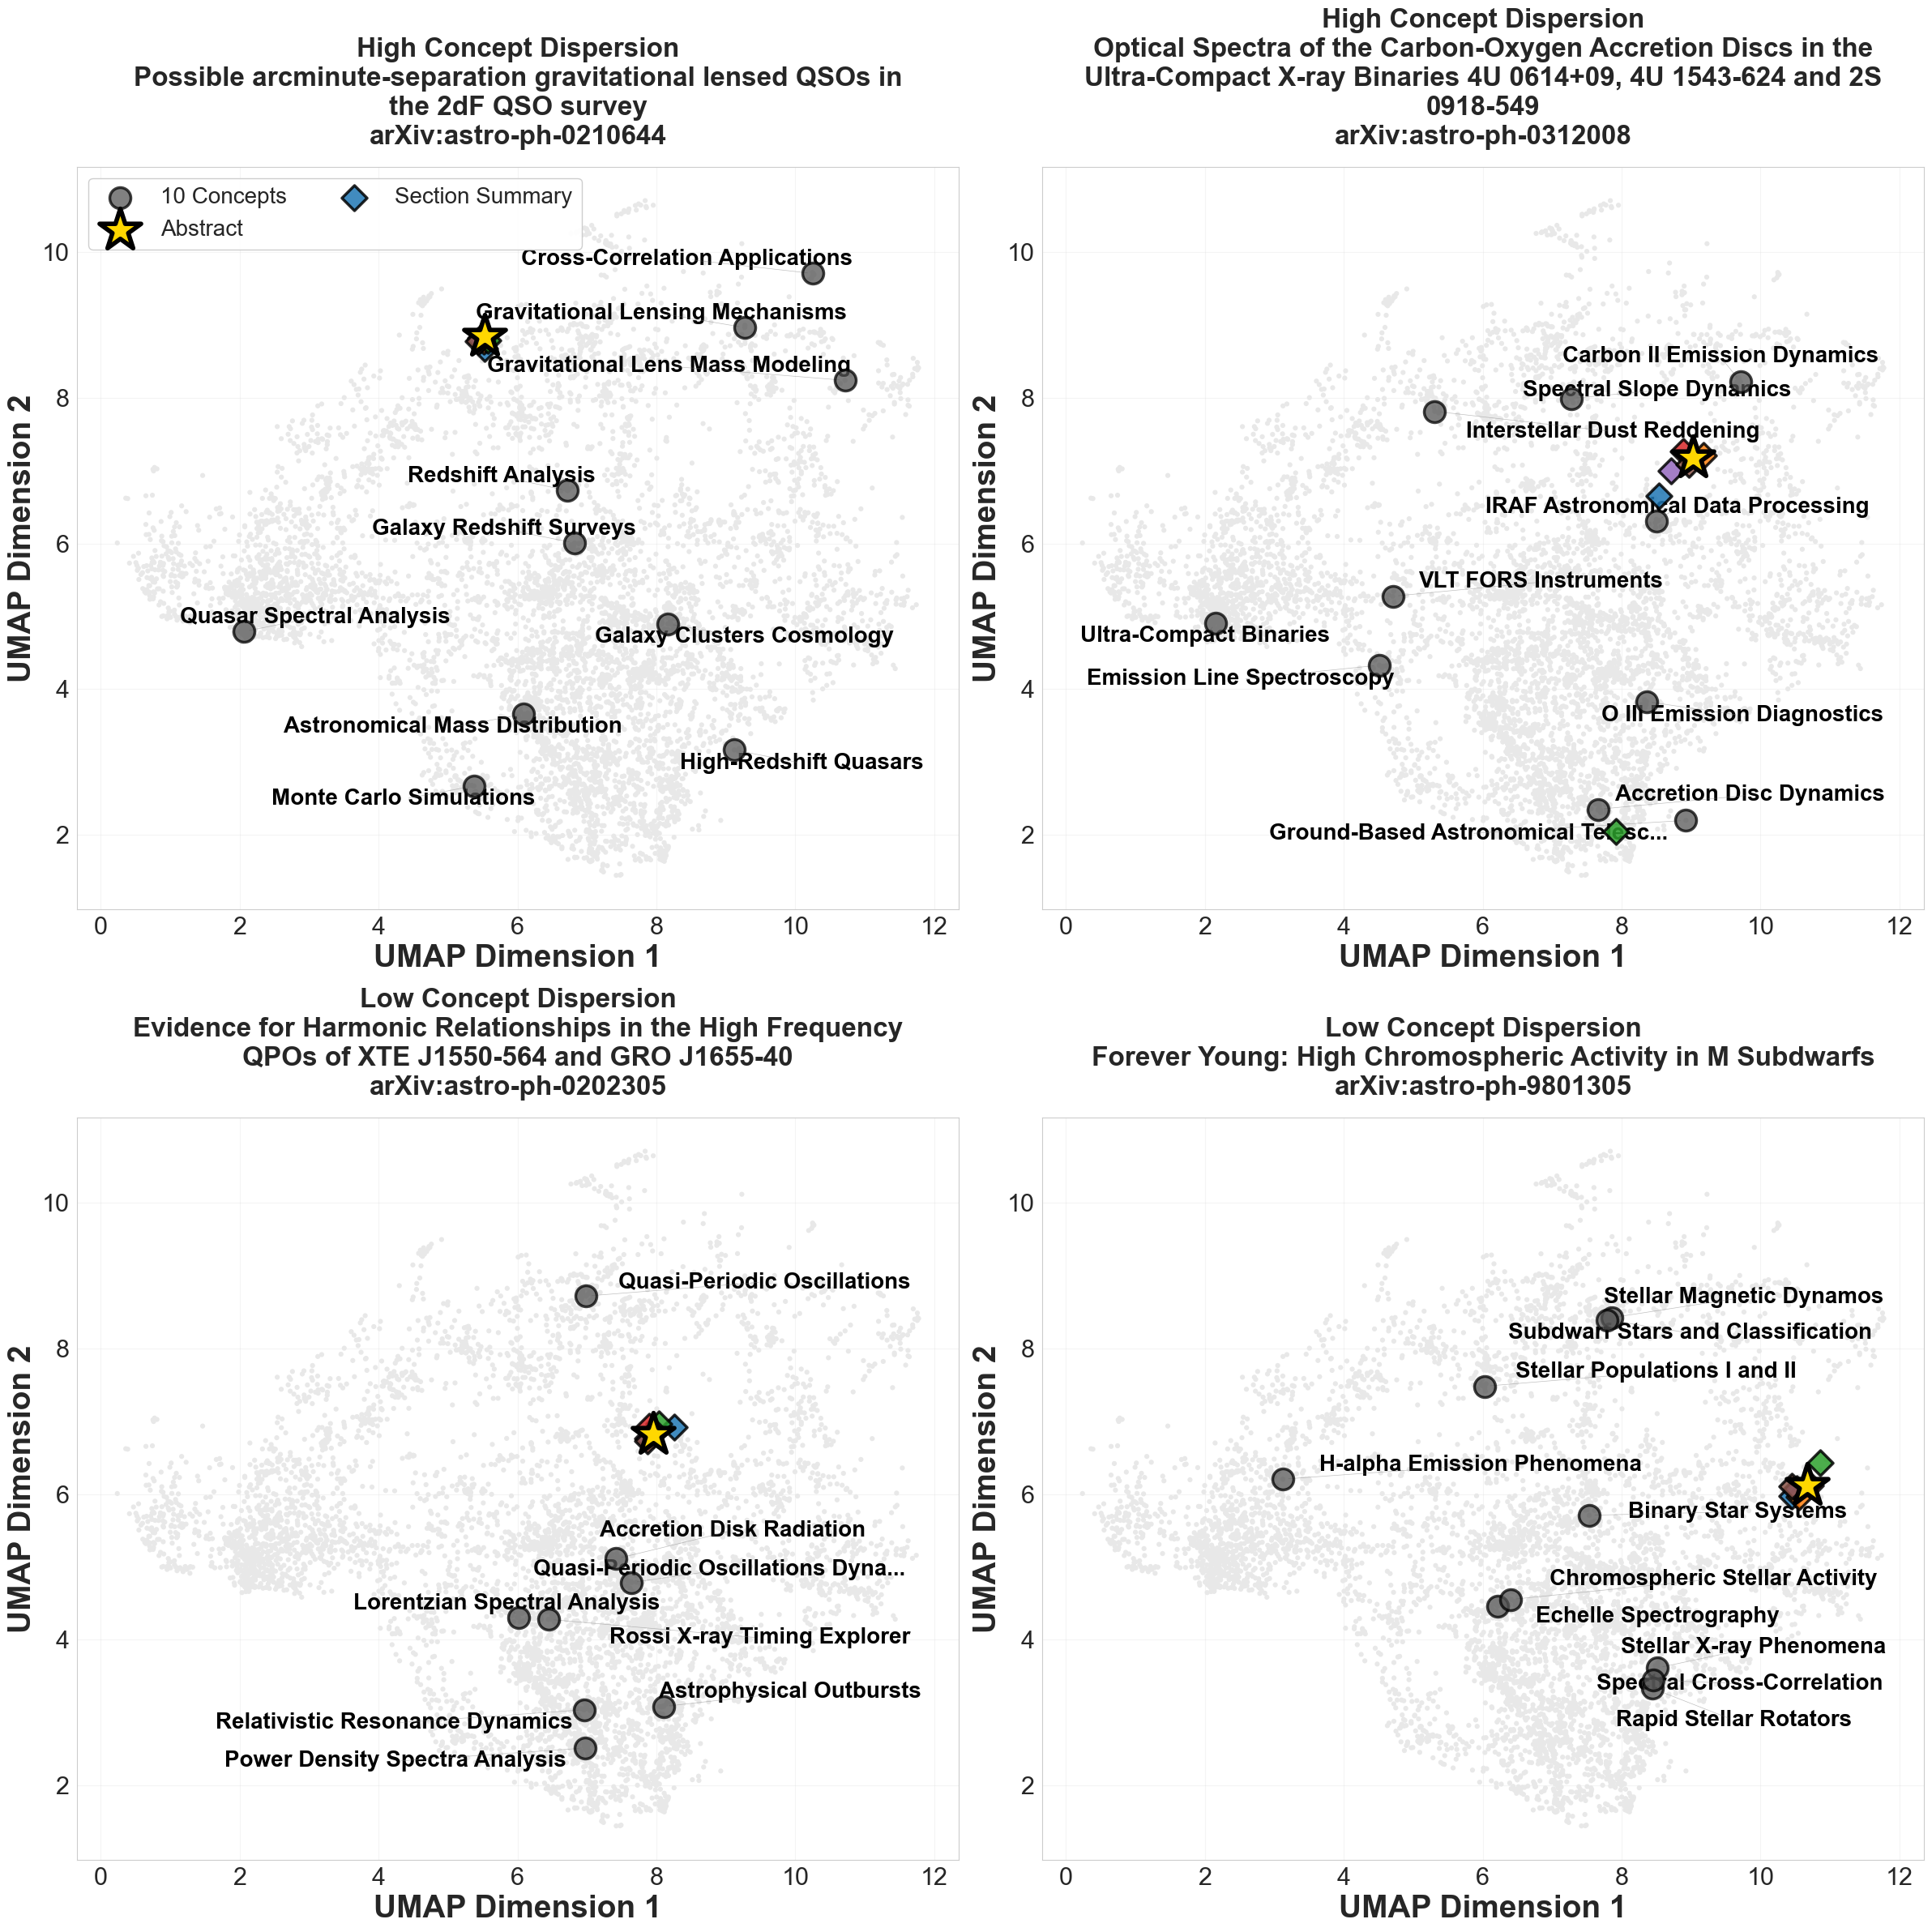


✅ Saved: figure_embedding_umap.png


In [7]:
from adjustText import adjust_text
import textwrap

# Section colors (professional)
section_colors = {
    'background': '#1f77b4',
    'motivation': '#ff7f0e',
    'methodology': '#2ca02c',
    'results': '#d62728',
    'interpretation': '#9467bd',
    'implication': '#8c564b'
}

# Get all concept embeddings for background (compute once)
all_concepts_2d = embedding_2d[concept_mask]

fig, axes = plt.subplots(2, 2, figsize=(24, 24))
axes = axes.flatten()

for plot_idx, (idx, row) in enumerate(selected_papers.iterrows()):
    ax = axes[plot_idx]
    arxiv_id = row['arxiv_id']
    
    # Plot background (all concepts, very faint) - FIRST
    ax.scatter(all_concepts_2d[:, 0], all_concepts_2d[:, 1],
              c='#E8E8E8', alpha=1.0, s=20, edgecolors='none', rasterized=True)
    
    # Get concepts
    paper_concept_labels = row['concept_labels']
    concept_indices = [label_to_subset_idx[label] for label in paper_concept_labels]
    concept_2d = embedding_2d[concept_mask][concept_indices]
    
    # Get concept names
    concept_names = concept_vocab[concept_vocab['label'].isin(paper_concept_labels)]['concept'].values
    
    # Get abstract
    abstract_idx = len(concept_embeddings) + abstract_id_to_idx[arxiv_id]
    abstract_2d = embedding_2d[abstract_idx]
    
    # Get sections
    section_idx = section_id_to_idx[arxiv_id]
    paper_section_embs = np.array([section_embeddings[name][section_idx] for name in section_names])
    section_2d = reducer.transform(paper_section_embs)
    
    # Get title and wrap it
    title = paper_titles.get(arxiv_id, 'Unknown')
    title_wrapped = '\n'.join(textwrap.wrap(title, width=60))
    
    # This paper's concepts
    ax.scatter(concept_2d[:, 0], concept_2d[:, 1],
              c='#555555', s=350, alpha=0.75, edgecolors='black', linewidth=2.5, 
              label=f'{len(concept_2d)} Concepts', zorder=5)
    
    # Abstract (BRIGHT STAR)
    ax.scatter(abstract_2d[0], abstract_2d[1],
              c='#FFD700', s=1500, marker='*', edgecolors='black', linewidth=4, 
              label='Abstract', zorder=10)
    
    # 6 Sections (COLORED DIAMONDS)
    for j, section_name in enumerate(section_names):
        ax.scatter(section_2d[j, 0], section_2d[j, 1],
                  c=section_colors[section_name], s=250, marker='D', alpha=0.85,
                  edgecolors='black', linewidth=2.5, zorder=8,
                  label='Section Summary' if plot_idx == 0 and j == 0 else None)
    
    # Label concepts (no background, use adjustText)
    texts = []
    for j, (x, y, name) in enumerate(zip(concept_2d[:, 0], concept_2d[:, 1], concept_names)):
        if len(name) > 35:
            name = name[:32] + '...'
        t = ax.text(x, y, name, fontsize=20, ha='center', va='center',
                   color='black', fontweight='bold')
        texts.append(t)
    
    # Adjust text to avoid overlaps (with shrinkA to prevent arrows striking through text)
    adjust_text(texts, ax=ax, 
               arrowprops=dict(arrowstyle='-', color='gray', lw=0.5, alpha=0.5, shrinkA=5, shrinkB=5),
               expand_points=(1.5, 1.5), expand_text=(1.2, 1.2),
               force_text=(0.5, 0.5), force_points=(0.2, 0.2))
    
    # Styling
    disp_type = "High Concept Dispersion" if plot_idx < 2 else "Low Concept Dispersion"
    ax.set_xlabel('UMAP Dimension 1', fontsize=28, fontweight='bold')
    ax.set_ylabel('UMAP Dimension 2', fontsize=28, fontweight='bold')
    ax.set_title(
        f'{disp_type}\n{title_wrapped}\narXiv:{arxiv_id}',
        fontsize=24, fontweight='bold', pad=20
    )
    
    if plot_idx == 0:
        ax.legend(fontsize=20, loc='upper left', framealpha=0.95, ncol=2)
    
    ax.tick_params(labelsize=22)
    ax.grid(alpha=0.2, linewidth=0.8)
    
plt.tight_layout()
plt.savefig('figure_embedding_umap.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Saved: figure_embedding_umap.png")

## 4. Distribution Analysis Across All Papers

Beyond individual examples, we analyze similarity distributions across all 10,000 papers.

For each paper, we compute pairwise similarities and report:
- **p16** (16th percentile): Lower typical range
- **p50** (median): Central value
- **p84** (84th percentile): Upper typical range

The cumulative distributions show whether concepts are generally dispersed (lower similarities) while sections cluster (higher similarities) across the entire dataset.

### Calculate Percentiles

For each paper, we calculate the 16th, 50th (median), and 84th percentiles of pairwise similarities.


In [8]:
print("Calculating per-paper percentiles...")

# For each paper, store p16, p50, p84
concept_p16_per_paper = []
concept_p50_per_paper = []
concept_p84_per_paper = []

section_p16_per_paper = []
section_p50_per_paper = []
section_p84_per_paper = []

for arxiv_id in section_ids:
    # Concept similarities
    paper_concept_labels = paper_concepts_sample[
        paper_concepts_sample['arxiv_id'] == arxiv_id
    ]['label'].values
    
    if len(paper_concept_labels) >= 2:
        concept_indices = [label_to_subset_idx[label] for label in paper_concept_labels]
        concept_embs = concept_embeddings[concept_indices]
        sims = cosine_similarity(concept_embs)
        pairs = sims[np.triu_indices_from(sims, k=1)]
        
        if len(pairs) > 0:
            concept_p16_per_paper.append(np.percentile(pairs, 16))
            concept_p50_per_paper.append(np.percentile(pairs, 50))
            concept_p84_per_paper.append(np.percentile(pairs, 84))
    
    # Section similarities
    section_idx = section_id_to_idx[arxiv_id]
    section_embs = np.array([section_embeddings[name][section_idx] for name in section_names])
    sims = cosine_similarity(section_embs)
    pairs = sims[np.triu_indices_from(sims, k=1)]
    
    section_p16_per_paper.append(np.percentile(pairs, 16))
    section_p50_per_paper.append(np.percentile(pairs, 50))
    section_p84_per_paper.append(np.percentile(pairs, 84))

concept_p16_per_paper = np.array(concept_p16_per_paper)
concept_p50_per_paper = np.array(concept_p50_per_paper)
concept_p84_per_paper = np.array(concept_p84_per_paper)

section_p16_per_paper = np.array(section_p16_per_paper)
section_p50_per_paper = np.array(section_p50_per_paper)
section_p84_per_paper = np.array(section_p84_per_paper)

print(f"\n✅ Papers with concept data: {len(concept_p16_per_paper):,}")
print(f"✅ Papers with section data: {len(section_p16_per_paper):,}")

Calculating per-paper percentiles...

✅ Papers with concept data: 2,514
✅ Papers with section data: 10,000


### Plot Cumulative Distributions

We plot the cumulative distributions to show how concept and section similarities differ across all papers.


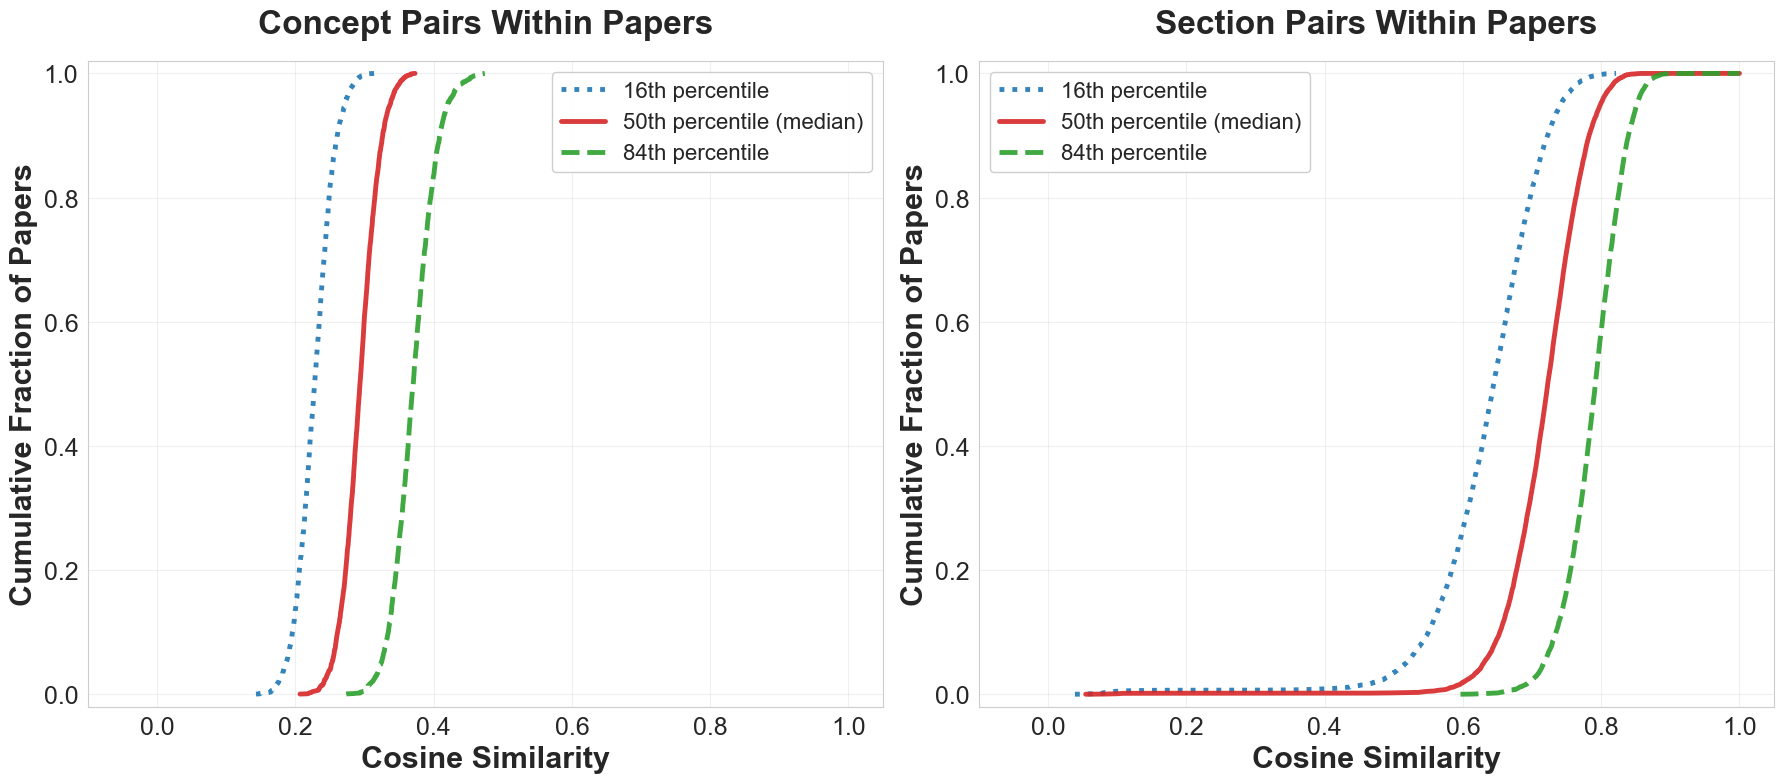


✅ Saved: figure_embedding_distributions.png

Concept p50 statistics:
  Median: 0.294
  Mean: 0.294

Section p50 statistics:
  Median: 0.723
  Mean: 0.719


In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Left: Concept percentiles
for data, label, color, ls in [
    (concept_p16_per_paper, '16th percentile', '#1f77b4', ':'),
    (concept_p50_per_paper, '50th percentile (median)', '#d62728', '-'),
    (concept_p84_per_paper, '84th percentile', '#2ca02c', '--')
]:
    sorted_data = np.sort(data)
    cumulative = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    ax1.plot(sorted_data, cumulative, linewidth=3.5, color=color, 
            linestyle=ls, label=label, alpha=0.9)

ax1.set_xlabel('Cosine Similarity', fontsize=22, fontweight='bold')
ax1.set_ylabel('Cumulative Fraction of Papers', fontsize=22, fontweight='bold')
ax1.set_title('Concept Pairs Within Papers', fontsize=24, fontweight='bold', pad=20)
ax1.legend(fontsize=16, loc='upper right', framealpha=0.95)
ax1.grid(alpha=0.3, linewidth=0.8)
ax1.tick_params(labelsize=18)
ax1.set_xlim(-0.1, 1.05)
ax1.set_ylim(-0.02, 1.02)

# Right: Section percentiles
for data, label, color, ls in [
    (section_p16_per_paper, '16th percentile', '#1f77b4', ':'),
    (section_p50_per_paper, '50th percentile (median)', '#d62728', '-'),
    (section_p84_per_paper, '84th percentile', '#2ca02c', '--')
]:
    sorted_data = np.sort(data)
    cumulative = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    ax2.plot(sorted_data, cumulative, linewidth=3.5, color=color,
            linestyle=ls, label=label, alpha=0.9)

ax2.set_xlabel('Cosine Similarity', fontsize=22, fontweight='bold')
ax2.set_ylabel('Cumulative Fraction of Papers', fontsize=22, fontweight='bold')
ax2.set_title('Section Pairs Within Papers', fontsize=24, fontweight='bold', pad=20)
ax2.legend(fontsize=16, loc='upper left', framealpha=0.95)
ax2.grid(alpha=0.3, linewidth=0.8)
ax2.tick_params(labelsize=18)
ax2.set_xlim(-0.1, 1.05)
ax2.set_ylim(-0.02, 1.02)

plt.tight_layout()
plt.savefig('figure_embedding_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Saved: figure_embedding_distributions.png")
print(f"\nConcept p50 statistics:")
print(f"  Median: {np.median(concept_p50_per_paper):.3f}")
print(f"  Mean: {np.mean(concept_p50_per_paper):.3f}")
print(f"\nSection p50 statistics:")
print(f"  Median: {np.median(section_p50_per_paper):.3f}")
print(f"  Mean: {np.mean(section_p50_per_paper):.3f}")

## 5. Summary

The analysis reveals clear differences in how concepts and summaries are distributed in embedding space:

**Concepts are dispersed**: Median similarity ~0.29, meaning concepts assigned to the same paper often represent different semantic regions (e.g., astrophysics + machine learning + statistics).

**Sections cluster**: Median similarity ~0.72, meaning the 6 summary sections describe the same research from different angles.

**Implication**: This validates using concepts for broad discovery (a paper can be found via multiple topical entry points) and summaries for detailed comprehension (coherent narrative after discovery).